# Generative Adversarial Networks in Keras

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## The original GAN!

See [this paper](https://arxiv.org/abs/1406.2661) for details of the approach we'll try first for our first GAN. We'll see if we can generate hand-drawn numbers based on MNIST, so let's load that dataset first.

We'll be refering to the discriminator as 'D' and the generator as 'G'.

In [85]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [3]:
n = len(X_train)

In [4]:
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [5]:
X_train /= 255.; X_test /= 255.

## Train

This is just a helper to plot a bunch of generated images.

In [6]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

Create some random data for the generator.

In [7]:
def noise(bs): return np.random.rand(bs,100)

Create a batch of some real and some generated data, with appropriate labels, for the discriminator.

In [8]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz + [1]*sz

In [9]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [94]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        X,y = data_D(bs//2, G)
        
        dl.append(D.train_on_batch(X,y)) #train_on_batch - keras function, single gradient update
        make_trainable(D, False)
        
        g_loss=m.train_on_batch(noise(bs), np.zeros([bs]))
        gl.append(g_loss)
        
        make_trainable(D, True)
        if e % 200==0:
            plot_gen(G)
    return dl,gl

## MLP GAN

We'll keep thinks simple by making D & G plain ole' MLPs.

In [166]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid'),
])

In [168]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")

In [169]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [160]:
dl,gl = train(MLP_D, MLP_G, 4000)

100%|██████████| 4000/4000 [00:47<00:00, 84.49it/s]    | 8/4000 [00:00<00:55, 71.74it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

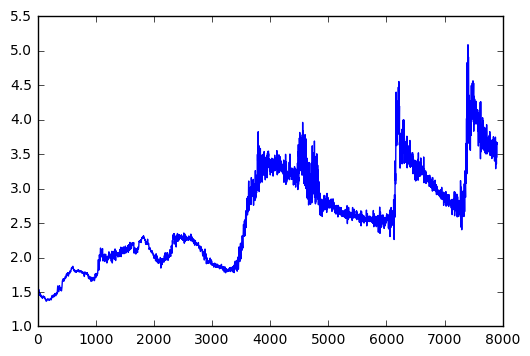

In [161]:
plt.plot(dl[100:])

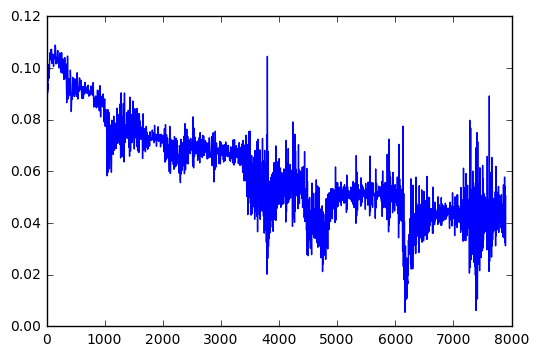

In [162]:
plt.plot(gl[100:])

This is what's known in the literature as "mode collapse".

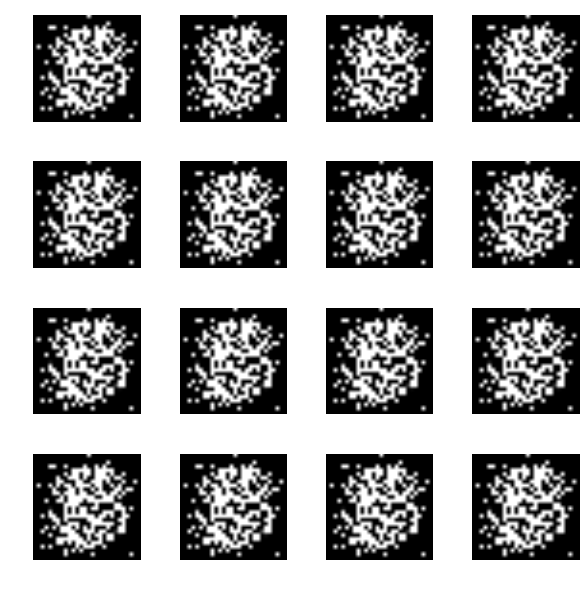

In [165]:
plot_gen()

OK, so that didn't work. Can we do better?...

## DCGAN

There's lots of ideas out there to make GANs train better, since they are notoriously painful to get working. The [paper introducing DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. Add see https://github.com/soumith/ganhacks for many tips!

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [104]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

In [105]:
np.min(X_train)

0

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

In [106]:
CNN_G = Sequential([
    Dense(512*7*7, input_dim=100, activation=LeakyReLU()),
    BatchNormalization(mode=2),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Convolution2D(64, 3, 3, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(mode=2),
    UpSampling2D(),
    Convolution2D(32, 3, 3, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(mode=2),
    Convolution2D(1, 1, 1, border_mode='same', activation='sigmoid')
])

The discriminator uses a few downsampling steps through strided convolutions.

In [107]:
CNN_D = Sequential([
    Convolution2D(256, 5, 5, subsample=(2,2), border_mode='same', 
                  input_shape=(28, 28, 1), activation=LeakyReLU()),
    Convolution2D(512, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU()),
    Flatten(),
    Dense(256, activation=LeakyReLU()),
    Dense(1, activation = 'sigmoid')
])

CNN_D.compile(Adam(1e-3), "binary_crossentropy")

We train D a "little bit" so it can at least tell a real image from random noise.

In [108]:
sz = n//200
#X_train=X_train*2-1 #gidi, according tip
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])

CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, nb_epoch=1, verbose=2)

Epoch 1/1
1s - loss: 2.0251


In [109]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [110]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

Now we can train D & G iteratively.

100%|██████████| 250/250 [01:27<00:00,  3.04it/s]


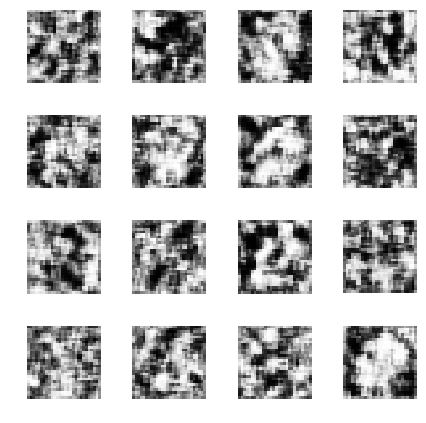

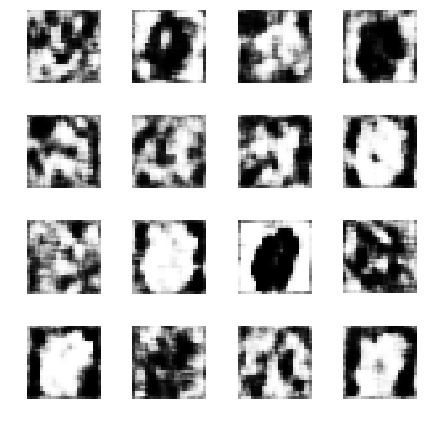

In [111]:
#vanila
dl,gl = train(CNN_D, CNN_G, CNN_m, 250)

100%|██████████| 250/250 [01:26<00:00,  3.01it/s]


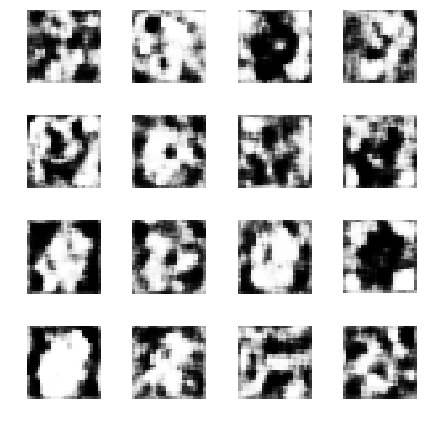

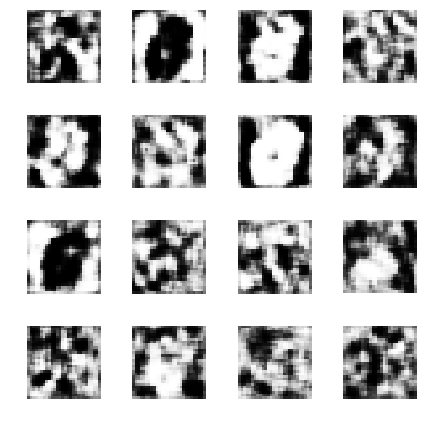

In [112]:
dl,gl = train(CNN_D, CNN_G, CNN_m, 250)

100%|██████████| 400/400 [02:17<00:00,  2.99it/s]


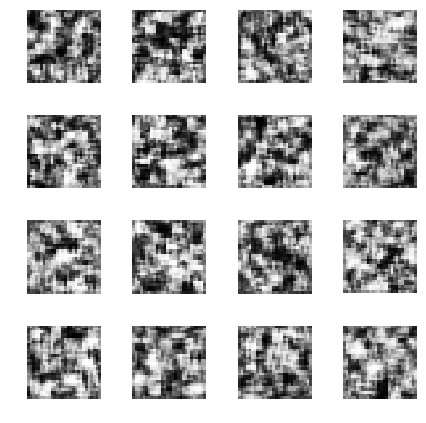

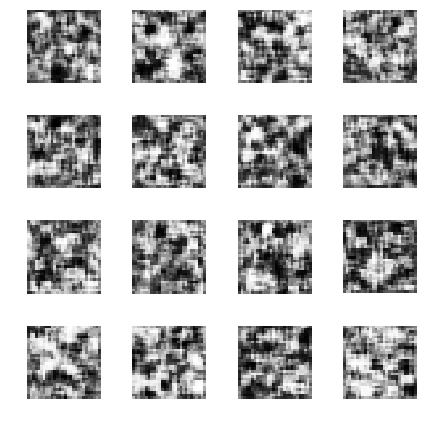

In [103]:
#, normalize input - didnt work
# waasserstein loss on both - didnt work
dl,gl = train(CNN_D, CNN_G, CNN_m, 400)

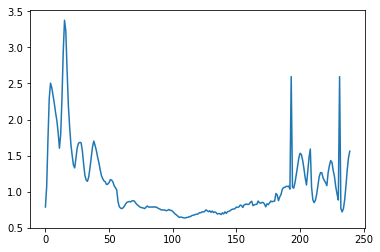

In [35]:
plt.plot(dl[10:])

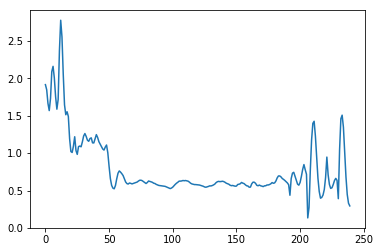

In [36]:
plt.plot(gl[10:])

## End

In [ ]:
#imporvments:
# 1 normalize input to -1,1
# 2 use tanh

In [58]:
#wasserstein loss finction
def wasserstein(y_true, y_pred):

    # return K.mean(y_true * y_pred) / K.mean(y_true)
    return K.mean(y_true * y_pred)